### Perform Clustering(Hierarchical, Kmeans & DBSCAN) for the crime data and identify the number of clusters formed and draw inferences.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Importing data
df = pd.read_csv(r"crime_data.csv")

In [6]:
df.head(5)

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [7]:
df.shape

(50, 5)

In [8]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [9]:
# Checking datatypes
df.dtypes

Unnamed: 0     object
Murder        float64
Assault         int64
UrbanPop        int64
Rape          float64
dtype: object

In [10]:
# Checking dupliacte values
df[df.duplicated()]

,Unnamed: 0,Murder,Assault,UrbanPop,Rape


In [11]:
# Finding Missing Values
df[df.isnull().any(axis=1)]

,Unnamed: 0,Murder,Assault,UrbanPop,Rape


#### Dataframe to check the outliers 

In [12]:
ol_df = df[["Murder", "Assault", "UrbanPop", "Rape"]]

In [13]:
ol_df.head(2)

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5


### Using Box Plot to detect the outliers 

Indices of outliers from the box plots:
[1, 27]
2


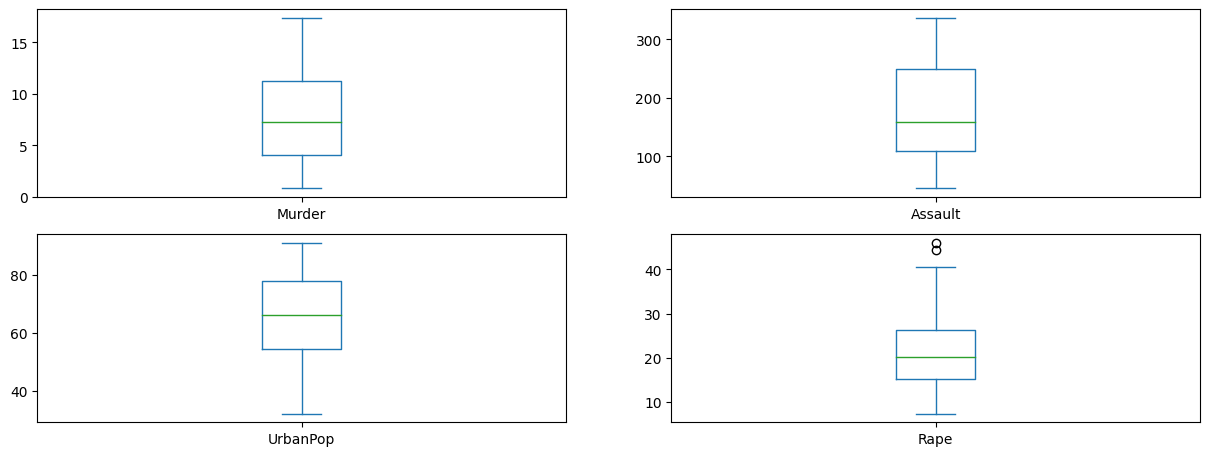

In [14]:
# Box plot find the outliers 

box_plot = ol_df.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = ol_df.quantile(0.25)
Q3 = ol_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(ol_df.columns, box_plot):
    outliers = ((ol_df[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (ol_df[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = ol_df.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)
print(len(outlier_indices))

### Using IQR to detect the outliers

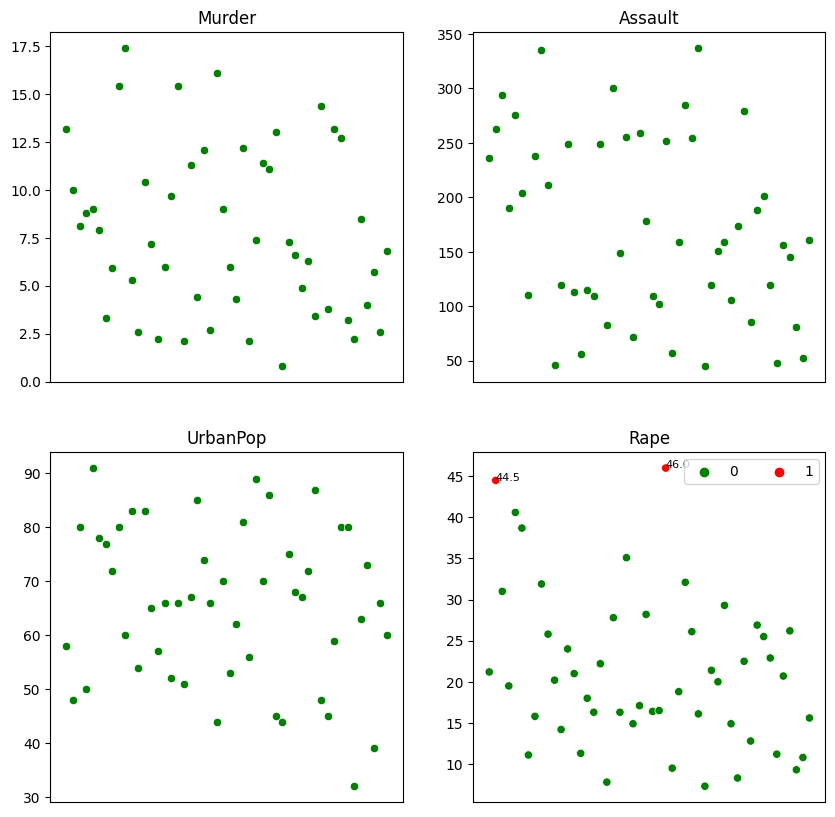

Row indices of potential outliers:
Int64Index([1, 27], dtype='int64')


In [15]:
#FUNCTION TO IDENTIFY OUTLIERS USING IQR METHOD
def iqr_outlier(x,factor):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result_ = pd.Series([0] * len(x))
    result_[((x < min_) | (x > max_))] = 1
    return result_
#SCATTER PLOTS HIGHLIGHTING OUTLIERS CALCULATED USING IQR METHOD
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
row = col = 0
for n,i in enumerate(ol_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = iqr_outlier(ol_df[i], 1.5)
   
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(ol_df[i])), y = ol_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(ol_df[i])), y = ol_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(ol_df[i]))[outliers == 1], ol_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1
plt.show()

# Calculate the IQR for each variable
Q1 = ol_df.quantile(0.25)
Q3 = ol_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Identify potential outliers based on the IQR method
outliers = ((ol_df < (Q1 - IQR_multiplier * IQR)) | (ol_df > (Q3 + IQR_multiplier * IQR)))

# Get the row indices of potential outliers
row_indices = ol_df.index[outliers.any(axis=1)]

# Print the row indices of potential outliers
print("Row indices of potential outliers:")
print(row_indices)

### Using Z-Scores to detect the outliers

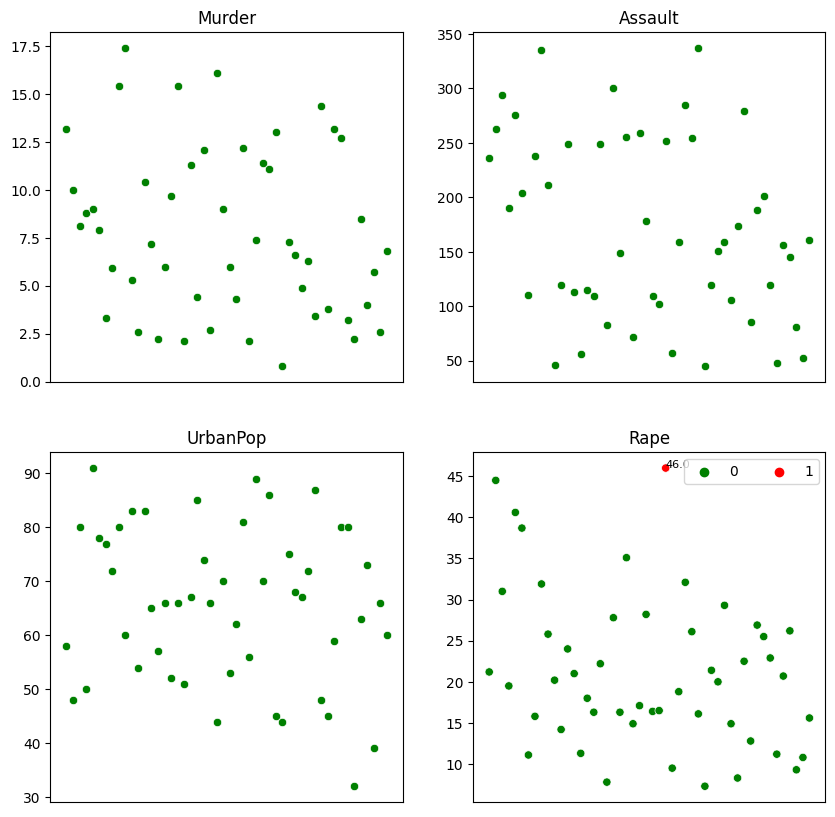

Outliers:
    Murder  Assault  UrbanPop  Rape
1     10.0      263        48  44.5
27    12.2      252        81  46.0


In [16]:
#FUNCTION TO DETECT OUTLIERS USING Z-SCORE METHOD
def zscore_outlier(x,lb,ub):
    zscore = ((x - x.mean()) / x.std()).copy()
    result_ = pd.Series([0] * len(x))
    result_[((zscore < lb) | (zscore > ub))] = 1
    return result_
#PLOTTING A SCATTER PLOT AND HIGHLIGHTING THE OUTLIERS DETECTED BY Z-SCORE METHOD
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
row = col = 0
for n,i in enumerate(ol_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = zscore_outlier(ol_df[i], -2.5, 2.5)
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(ol_df[i])), y = ol_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(ol_df[i])), y = ol_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(ol_df[i]))[outliers == 1], ol_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1

plt.show()

# Calculate z-scores for the 'Values' column
z_scores = stats.zscore(ol_df['Rape'])

# Set a z-score threshold for detecting outliers
z_score_threshold = 2.5 # Adjust as needed

# Identify outliers based on the z-scores
outliers = ol_df[abs(z_scores) > z_score_threshold]

# Display the outliers
print("Outliers:")
print(outliers)

### From the above methods we can conclude that records 1 and 27 are outliers with respect to Rape Feature. Hence need to be treated. We are replacing the outlier with the median value.

### Outlier treatment for HP feature

In [17]:
# Select a specific feature (column)
selected_feature = 'Rape'
feature_values = df[selected_feature]

# Calculate the median of the selected feature
median_value = feature_values.median()

# Calculate quartiles and IQR for the selected feature
Q1 = feature_values.quantile(0.25)
Q3 = feature_values.quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
outlier_threshold = 1.5 * IQR

# Identify outlier indices within the selected feature
outlier_indices = feature_values[(feature_values < Q1 - outlier_threshold) | 
                                 (feature_values > Q3 + outlier_threshold)].index

# Replace outliers with the median
df.loc[outlier_indices, selected_feature] = median_value

### Boxplot after treating outliers in Rape 

Indices of outliers from the box plots:
[]
0


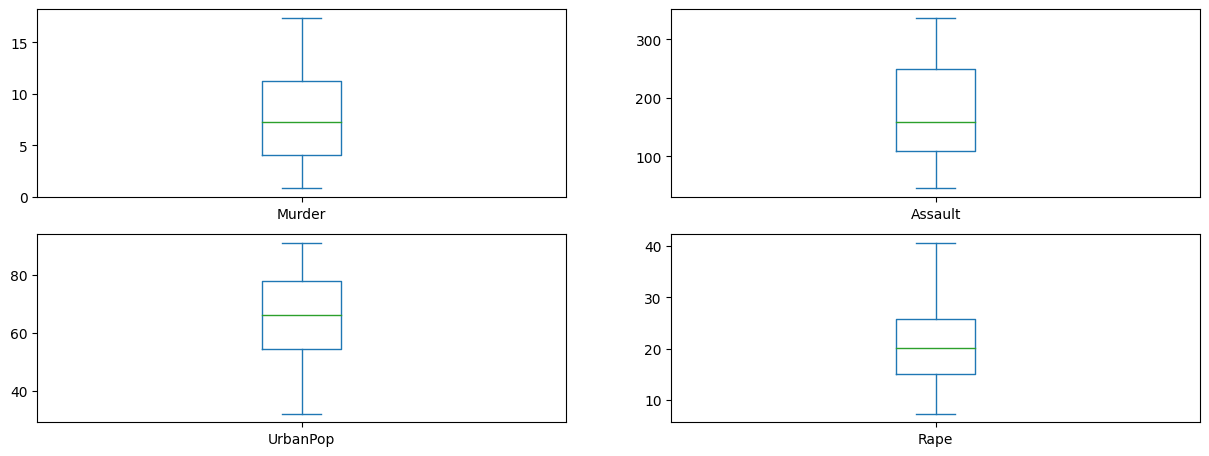

In [18]:
clean_df = df[["Murder", "Assault", "UrbanPop", "Rape"]]

# Box plot find the outliers 

box_plot = clean_df.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = clean_df.quantile(0.25)
Q3 = clean_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(clean_df.columns, box_plot):
    outliers = ((clean_df[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (clean_df[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = clean_df.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)
print(len(outlier_indices))

In [19]:
cont_df = df[["Murder", "Assault", "UrbanPop", "Rape"]]

In [20]:
# Correlation matrix to check the multi collinearity of the features
cont_df.corr()

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.564926
Assault,0.801873,1.000000,0.258872,0.649735
UrbanPop,0.069573,0.258872,1.000000,0.489600
Rape,0.564926,0.649735,0.489600,1.000000


<AxesSubplot: >

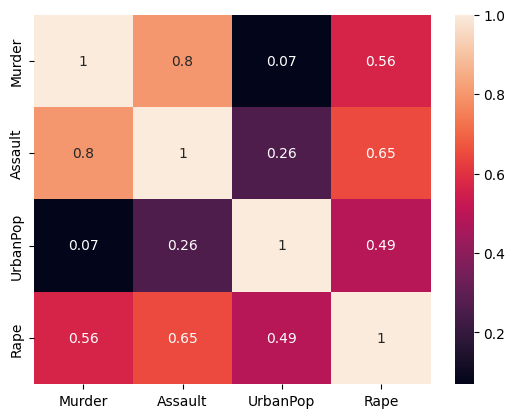

In [21]:
# Heatmaps for the given dataset.
sns.heatmap(cont_df.corr(), annot=True)

### None of the values is near or equal to 1 or -1. Hence no multicolinearity present.


In [22]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

vif_results = calculate_vif(cont_df)  
print("VIF Results:")
print(vif_results)

VIF Results:
    feature        VIF
0    Murder  12.352190
1   Assault  17.979221
2  UrbanPop  10.300858
3      Rape  16.987478


### VIF value for all the features is very low. Hence all the variables are significant and there is no presence of multicollinearity.
### From both the correlation matrix and the VIF value show that none of the feature depend on each other. Hence there is no multicollinearity present in the dataset.

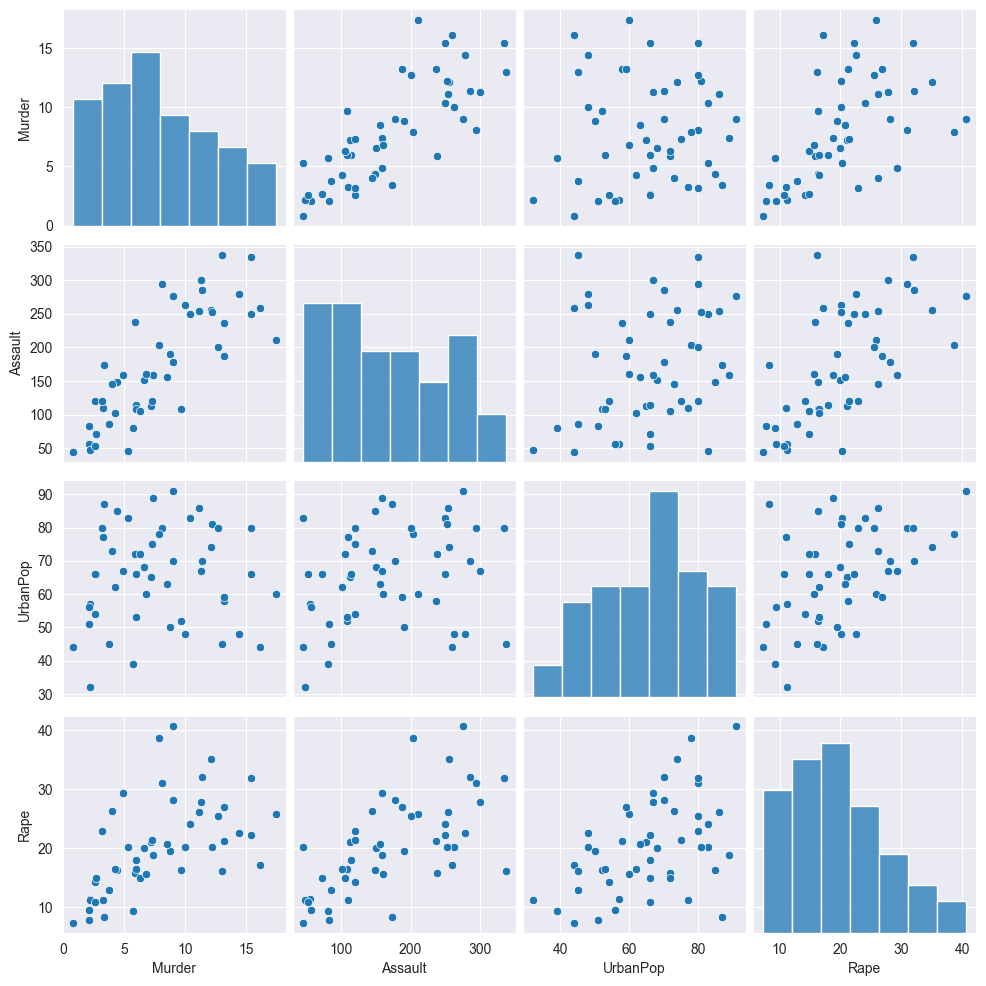

In [23]:
# Drawing Histogram to check the distribution of the data.
#Format the plot background and scatter plots for all the variables
sns.set_style(style='darkgrid')
sns.pairplot(cont_df)

### Each of the histogram shows that most the features are normally distributed.

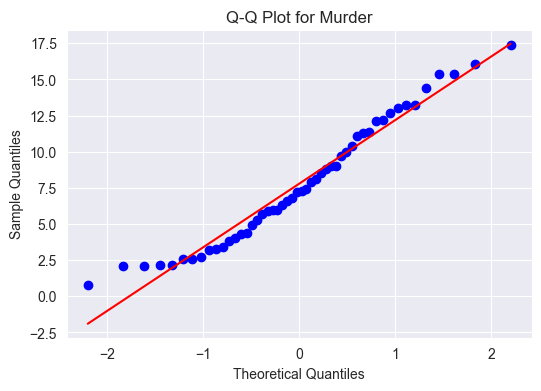

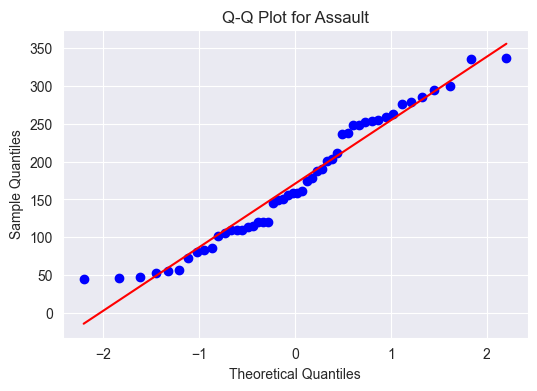

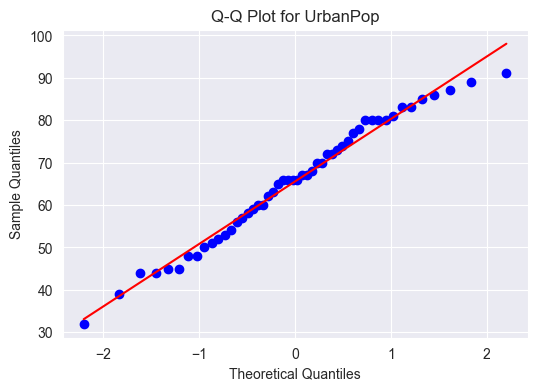

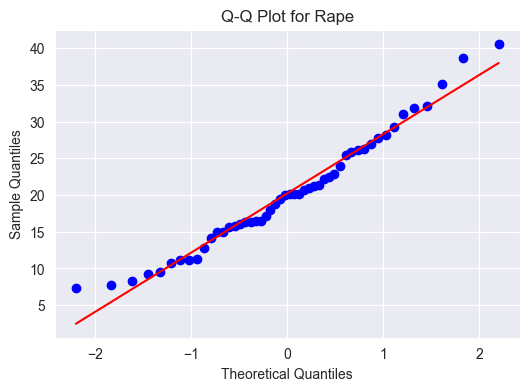

In [24]:
# Using Q-Q plot for checking the data distribution
# Create Q-Q plots for each variable in separate graphs
for col in cont_df.columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(cont_df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

### Each of the Q-Q plot shows that each of the feature is normally distributed.
### Hence we can use Standardization for transformation.

In [25]:
# Standardization function 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_crime_df = scaler.fit_transform(df.iloc[:,1:])

# K-means clustering

### To choose the optimum cluster we use elbow method. 

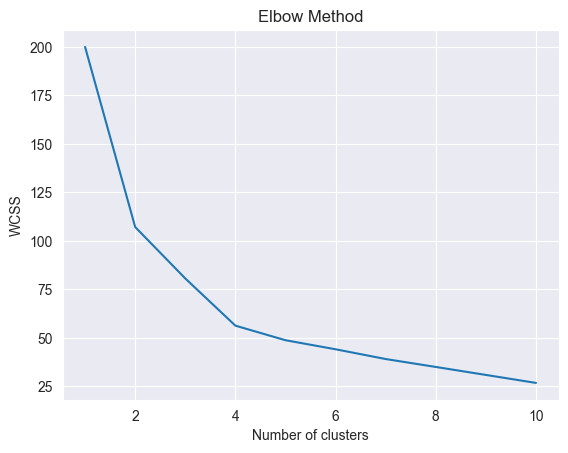

In [26]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(scaled_crime_df)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### After the 5 clusters the slope is almost constant. Hence 5 is optimum cluster value. 

### Building cluster model 

In [27]:
#Build Cluster algorithm
from sklearn.cluster import KMeans
clusters_new = KMeans(5, random_state=42)
clusters_new.fit(scaled_crime_df)

KMeans(n_clusters=5, random_state=42)

In [28]:
clusters_new.labels_

array([3, 3, 0, 2, 0, 0, 4, 2, 0, 3, 4, 1, 0, 2, 1, 2, 2, 3, 1, 0, 4, 0,
       1, 3, 2, 1, 2, 0, 1, 4, 0, 0, 3, 1, 2, 2, 2, 4, 4, 3, 1, 3, 0, 4,
       1, 2, 2, 1, 1, 2])

In [29]:
#Assign clusters to the data set
df['clusterid_new'] = clusters_new.labels_

In [30]:
#these are standardized values.
clusters_new.cluster_centers_

array([[ 0.75759426,  1.13128272,  0.94567938,  1.27563807],
       [-1.11467476, -1.17725513, -1.00201665, -1.12050133],
       [-0.21843787, -0.26375734, -0.04842155,  0.05437304],
       [ 1.4610129 ,  0.99381728, -0.84023734,  0.16031836],
       [-0.7029322 , -0.57371376,  1.13872696, -0.5279858 ]])

In [31]:
df.groupby('clusterid_new').agg(['mean']).reset_index()

,clusterid_new,Murder,Assault,UrbanPop,Rape
,,mean,mean,mean,mean
0,0,11.054545,264.090909,79.090909,30.263636
1,1,2.981818,73.636364,51.181818,11.409091
2,2,6.846154,149.000000,64.846154,20.653846
3,3,14.087500,252.750000,53.500000,21.487500
4,4,4.757143,123.428571,81.857143,16.071429


In [32]:
df.head(5)

,Unnamed: 0,Murder,Assault,UrbanPop,Rape,clusterid_new
0,Alabama,13.2,236,58,21.2,3
1,Alaska,10.0,263,48,20.1,3
2,Arizona,8.1,294,80,31.0,0
3,Arkansas,8.8,190,50,19.5,2
4,California,9.0,276,91,40.6,0


# Hierarchical clustering

In [33]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn

### Drawing dendrogram for each linkage to find the optimum number of clusters

### Dendrogram of single linkage 

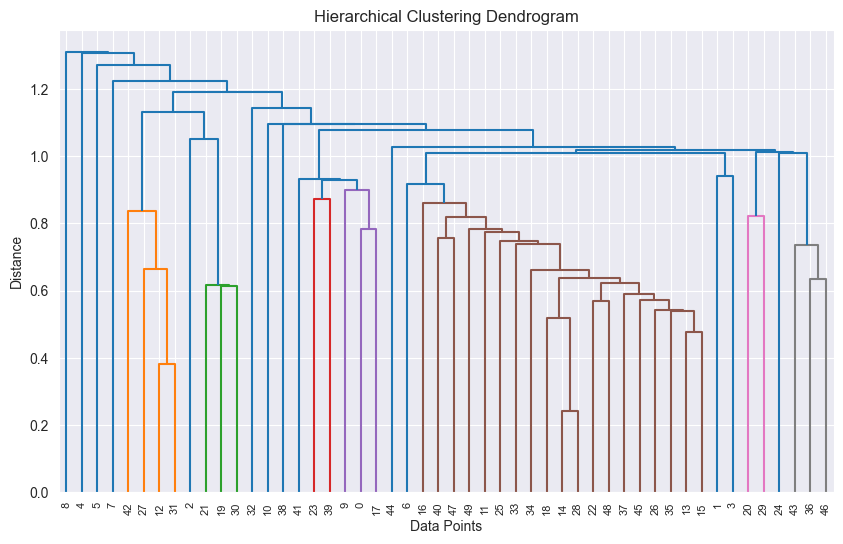

In [34]:
# create dendrogram

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_crime_df, method='single'))
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Dendrogram of complete linkage 

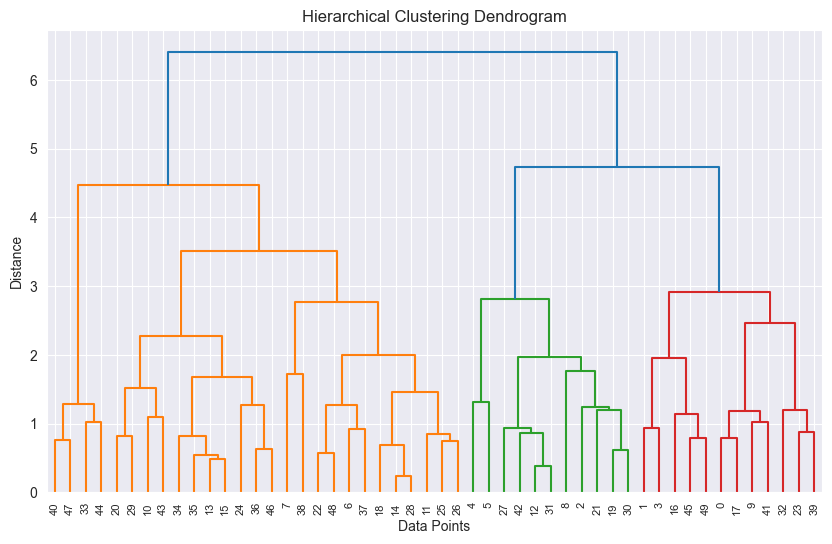

In [35]:
# create dendrogram

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_crime_df, method='complete'))
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Dendrogram of average linkage

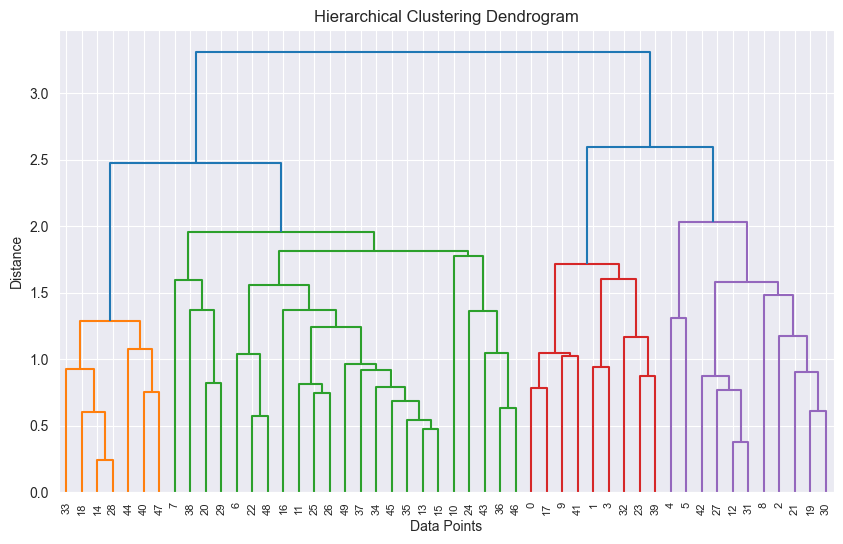

In [36]:
# create dendrogram

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_crime_df, method='average'))
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Dendrogram of centroid linkage

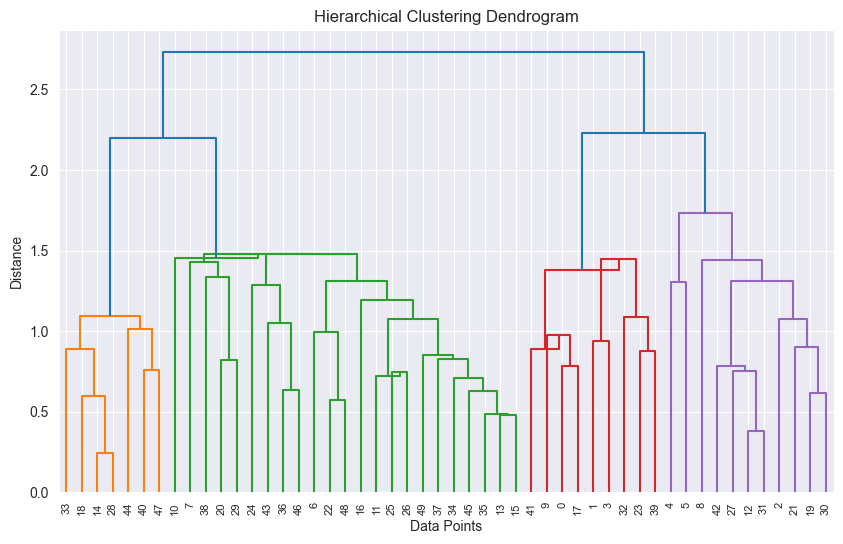

In [37]:
# create dendrogram

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_crime_df, method='centroid'))
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Dendrogram of ward linkage

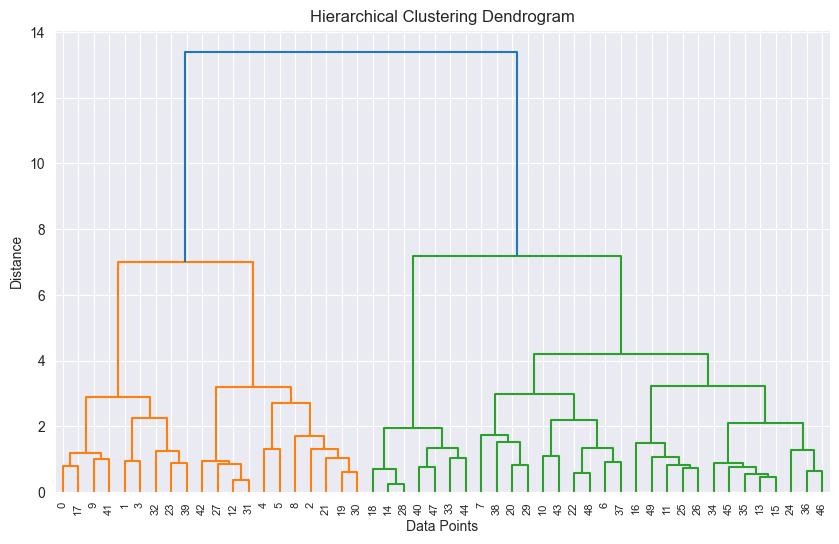

In [38]:
# create dendrogram

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_crime_df, method='ward'))
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### From the dendrogram we can see different clustering.
### Single linkage - 8 clusters
### Complete linkage - 4 clusters
### Average linkage - 5 clusters
### Centroid linkage - 5 clusters
### Ward linkage - 3 clusters

### From the above clustering we can conclude that 5 is the optimum number of clustering as average linkage suggest the same. 

In [39]:
# create clusters
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'average')

In [40]:
# save clusters for chart
y_hc = hc.fit_predict(scaled_crime_df)
Clusters=pd.DataFrame(y_hc,columns=['Clusters'])

In [41]:
Clusters.head(5)

,Clusters
0,2
1,2
2,1
3,2
4,4


In [42]:
h_df = df.drop(['clusterid_new'], axis=1)

In [43]:
# Concatenate the original dataframe qaqnd cluster dataframe
heir_df = pd.concat([h_df, Clusters], axis=1)

In [44]:
heir_df.head(5)

,Unnamed: 0,Murder,Assault,UrbanPop,Rape,Clusters
0,Alabama,13.2,236,58,21.2,2
1,Alaska,10.0,263,48,20.1,2
2,Arizona,8.1,294,80,31.0,1
3,Arkansas,8.8,190,50,19.5,2
4,California,9.0,276,91,40.6,4


# DBSCAN Clustering 

In [47]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps = 1, min_samples = 3).fit(scaled_crime_df)
# Print the cluster labels
print(clustering.labels_)

[ 0 -1 -1 -1 -1 -1  1 -1 -1  0 -1  1  2  1  1  1  1  0  1  3 -1  3  1  0
 -1  1  1  2  1 -1  3  2 -1  1  1  1  4  1 -1  0  1  0  2  4 -1  1  4  1
  1  1]


### Visualization of clusters 

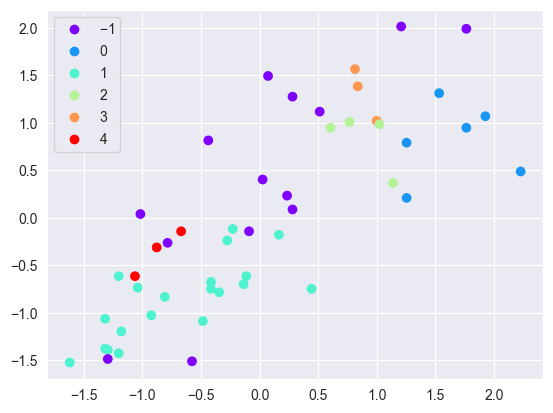

In [49]:
import matplotlib.pyplot as plt

# Plot the clusters
scatter = plt.scatter(scaled_crime_df[:, 0], scaled_crime_df[:, 1], c=clustering.labels_, cmap='rainbow')

# Add a legend
plt.legend(*scatter.legend_elements())


# Show the plot
plt.show()

### No of cluster is 5 if we dont count -1. 

In [50]:
cl=pd.DataFrame(clustering.labels_,columns=['cluster'])

In [51]:
dbscan_df = pd.concat([h_df,cl],axis=1)

In [52]:
dbscan_df.head(5)

,Unnamed: 0,Murder,Assault,UrbanPop,Rape,cluster
0,Alabama,13.2,236,58,21.2,0
1,Alaska,10.0,263,48,20.1,-1
2,Arizona,8.1,294,80,31.0,-1
3,Arkansas,8.8,190,50,19.5,-1
4,California,9.0,276,91,40.6,-1


# From all these three clustering methods we can conclude that 4 is the optimum clustering value. 